In [606]:
import requests
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import folium
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
from prophet import Prophet

# Load New York Electric Consumption Data

In [607]:
# Set up a session for NYC OpenData
s = requests.Session()
s.headers.update({
    'Referer': 'https://data.cityofnewyork.us',
    'User-Agent': 'Mozilla/5.0'
})

# Dataset ID for Electric Consumption And Cost
DATASET_ID = "jr24-e7cr"
download_url = f"https://data.cityofnewyork.us/api/views/{DATASET_ID}/rows.csv?accessType=DOWNLOAD"

# Request the dataset and load it into a DataFrame
response = s.get(download_url)

if response.status_code == 200:
    print(" Download successful!")
    csv_content = response.content.decode('utf-8')
    df_energy = pd.read_csv(StringIO(csv_content))
    display(df_energy.head())
else:
    print(f" Download failed. Status code: {response.status_code}")

df_energy['Revenue Month'] = pd.to_datetime(df_energy['Revenue Month'], errors='coerce')

df_consumption = df_energy.copy()

 Download successful!


/var/folders/88/cv10sc2j3t3849m762s6kglm0000gn/T/ipykernel_68974/2105333406.py:18: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_energy = pd.read_csv(StringIO(csv_content))


,Development Name,Borough,Account Name,Location,Meter AMR,Meter Scope,TDS #,EDP,RC Code,Funding Source,...,Meter Number,Estimated,Current Charges,Rate Class,Bill Analyzed,Consumption (KWH),KWH Charges,Consumption (KW),KW Charges,Other charges
0,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,15396.82,GOV/NYC/068,Yes,128800.0,7387.97,216.0,2808.0,5200.85
1,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,14556.34,GOV/NYC/068,Yes,115200.0,6607.87,224.0,2912.0,5036.47
2,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,13904.98,GOV/NYC/068,Yes,103200.0,5919.55,216.0,2808.0,5177.43
3,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,14764.04,GOV/NYC/068,Yes,105600.0,6057.22,208.0,2704.0,6002.82
4,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,13729.54,GOV/NYC/068,Yes,97600.0,5598.34,216.0,2808.0,5323.20


# Dataset Preprocessing

In [608]:
# Describe the Dataset (Numerical Values Only)
df_energy.describe()

,TDS #,EDP,UMIS BILL ID,Revenue Month,# days,Current Charges,Consumption (KWH),KWH Charges,Consumption (KW),KW Charges,Other charges
count,519157.000000,521035.000000,5.210350e+05,521035,521027.000000,521035.000000,5.210350e+05,521035.000000,521035.000000,521035.000000,521035.000000
mean,116.499202,424.929924,7.480257e+06,2018-03-01 22:34:30.406786304,30.361547,4284.955086,3.046078e+04,1433.879714,61.430595,858.910986,1992.164385
min,0.000000,63.000000,1.726303e+06,2010-01-01 00:00:00,-335.000000,-25622.210000,0.000000e+00,0.000000,0.000000,0.000000,-59396.430000
25%,33.000000,225.000000,3.788160e+06,2014-09-01 00:00:00,29.000000,649.990000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,63.000000,426.000000,6.542550e+06,2017-12-01 00:00:00,30.000000,2260.500000,1.192600e+04,527.790000,21.020000,249.400000,951.200000
75%,145.000000,552.000000,1.095094e+07,2021-11-01 00:00:00,31.000000,5601.970000,4.520000e+04,2051.190000,88.000000,1259.500000,2838.560000
max,582.000000,999.000000,1.488953e+07,2024-12-01 00:00:00,749.000000,424298.640000,2.788773e+06,195575.860000,329074.000000,78782.960000,312524.970000
std,128.773830,186.993741,4.033719e+06,NaN,2.596024,6210.140634,4.850114e+04,2463.710587,530.949951,1494.695516,3835.804306


In [609]:
# Describe the Dataset (For all Columns)
print(df_energy.describe(include='all'))

       Development Name   Borough Account Name Location Meter AMR  \
count            520414    521035       521035   507102    520266   
unique              379         7          361      536         7   
top            EDENWALD  BROOKLYN     EDENWALD   BLD 01       AMR   
freq              10233    199850        10233    60871    220446   
mean                NaN       NaN          NaN      NaN       NaN   
min                 NaN       NaN          NaN      NaN       NaN   
25%                 NaN       NaN          NaN      NaN       NaN   
50%                 NaN       NaN          NaN      NaN       NaN   
75%                 NaN       NaN          NaN      NaN       NaN   
max                 NaN       NaN          NaN      NaN       NaN   
std                 NaN       NaN          NaN      NaN       NaN   

             Meter Scope          TDS #            EDP  RC Code  \
count              27636  519157.000000  521035.000000   521035   
unique               108            N

In [610]:
# Check if there exists any Missing Values
print(df_energy.isnull().any().sum())

11


In [611]:
# Check for Duplicate Rows
duplicated_rows = df_energy[df_energy.duplicated()]

print(f"Number of Duplicate Rows: {len(duplicated_rows)}\n")
duplicated_rows.head()

Number of Duplicate Rows: 9980



,Development Name,Borough,Account Name,Location,Meter AMR,Meter Scope,TDS #,EDP,RC Code,Funding Source,...,Meter Number,Estimated,Current Charges,Rate Class,Bill Analyzed,Consumption (KWH),KWH Charges,Consumption (KW),KW Charges,Other charges
312691,HAMMEL,QUEENS,HAMMEL,BLD 08,NONE,Community Center,75.0,226,Q207500,FEDERAL,...,99268475,N,4371.11,281-Sec Com Large Gen Use,Yes,22920.0,2241.02,78.0,1212.43,917.66
313378,OCEAN BAY APARTMENTS (OCEANSIDE),QUEENS,OCEAN BAY APARTMENTS (OCEANSIDE),BLD 02 - Community Center,NONE,Community Center,51.0,573,Q205100,FEDERAL,...,80361609,N,1999.63,281-Sec Com Large Gen Use,Yes,8320.0,814.35,49.5,795.96,389.32
314901,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,13204.61,GOV/NYC/068,Yes,124000.0,4176.32,224.0,2237.76,6790.53
314902,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,14548.94,GOV/NYC/068,Yes,125600.0,4230.21,216.0,2157.84,8160.89
314913,ADAMS,BRONX,ADAMS,BLD 06,NONE,BLD 06,118.0,248,B011800,FEDERAL,...,9985100,N,8539.89,GOV/NYC/068,Yes,76400.0,2573.15,144.0,1438.56,4528.18


In [612]:
# Drop Duplicates
df = df_energy.drop_duplicates().reset_index(drop=True)

# Check for Duplicate Rows
duplicated_rows = df[df.duplicated()]

print(f"Number of Duplicate Rows: {len(duplicated_rows)}\n")
duplicated_rows.head()

Number of Duplicate Rows: 0



,Development Name,Borough,Account Name,Location,Meter AMR,Meter Scope,TDS #,EDP,RC Code,Funding Source,...,Meter Number,Estimated,Current Charges,Rate Class,Bill Analyzed,Consumption (KWH),KWH Charges,Consumption (KW),KW Charges,Other charges


In [613]:
print(df.columns.tolist())

['Development Name', 'Borough', 'Account Name', 'Location', 'Meter AMR', 'Meter Scope', 'TDS #', 'EDP', 'RC Code', 'Funding Source', 'AMP #', 'Vendor Name', 'UMIS BILL ID', 'Revenue Month', 'Service Start Date', 'Service End Date', '# days', 'Meter Number', 'Estimated', 'Current Charges', 'Rate Class', 'Bill Analyzed', 'Consumption (KWH)', 'KWH Charges', 'Consumption (KW)', 'KW Charges', 'Other charges']


In [614]:
# Dataset Preprocessing
df['datetime'] = pd.to_datetime(df['Revenue Month'], format='%Y-%m')
df['year'] = df['datetime'].dt.year
df['month_num'] = df['datetime'].dt.month

df = df.sort_values(by='datetime').reset_index(drop=True)
df.set_index('datetime', inplace=True, drop=True)

print(df[['Borough', 'year', 'month_num', 'Consumption (KWH)']].head())

             Borough  year  month_num  Consumption (KWH)
datetime                                                
2010-01-01     BRONX  2010          1           128800.0
2010-01-01     BRONX  2010          1            31200.0
2010-01-01  BROOKLYN  2010          1             1062.0
2010-01-01    QUEENS  2010          1              408.0
2010-01-01  BROOKLYN  2010          1              936.0


# Total monthly electricity consumption for all NYC regions

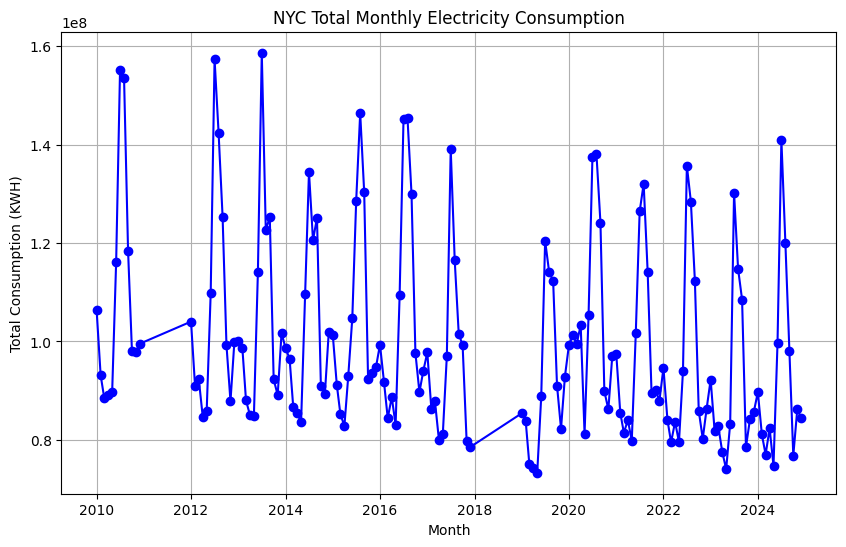

In [615]:
# Total monthly electricity consumption for all NYC regions
monthly_total = df.groupby('datetime')['Consumption (KWH)'].sum().reset_index()


plt.figure(figsize=(10, 6))
plt.plot(monthly_total['datetime'], monthly_total['Consumption (KWH)'], marker='o', color='blue')
plt.title('NYC Total Monthly Electricity Consumption')
plt.xlabel('Month')
plt.ylabel('Total Consumption (KWH)')
plt.grid(True)
plt.show()

# Check Boroughs and Development Names in Data

In [616]:
# Get all unique Boroughs
boroughs = df['Borough'].str.upper().unique()

# Define official NYC boroughs
nyc_boroughs = {"BRONX", "BROOKLYN", "MANHATTAN", "QUEENS", "STATEN ISLAND"}
other_labels = set(boroughs) - nyc_boroughs

print(" Official Boroughs of New York City:")
for b in nyc_boroughs:
    print(f" - {b}")

print("\n Other entries (not official boroughs):")
for o in other_labels:
    print(f" - {o}")

print()

# Display only the top 10 Development Names
development_names = df['Development Name'].dropna().unique()[:10]

print(" First 10 Development Names:")
for name in development_names:
    print(f" - {name}")




 Official Boroughs of New York City:
 - QUEENS
 - BROOKLYN
 - BRONX
 - MANHATTAN
 - STATEN ISLAND

 Other entries (not official boroughs):
 - FHA
 - NON DEVELOPMENT FACILITY

 First 10 Development Names:
 - ADAMS
 - SOTOMAYOR HOUSES
 - BUSHWICK II (GROUPS B & D)
 - INTERNATIONAL TOWER
 - BUSHWICK II CDA (GROUP E)
 - SOUTH BEACH
 - MARLBORO
 - SOUTH BRONX AREA (SITE 402)
 - STRAUS
 - ISAACS


# NYC Boroughs Energy Consumption Map
In this map, larger circles represent higher levels of electric consumption.

In [617]:
df['Borough'] = df['Borough'].str.upper()
df['Development Name'] = df['Development Name'].str.upper()


# Get the most recent full year (e.g., if max is 2025-Feb, use 2024)
latest_year = df['year'].max() - 1
df_latest = df[df['year'] == latest_year]

# Calculate total consumption by Borough for the latest year
borough_consumption = df_latest.groupby('Borough')['Consumption (KWH)'].sum().reset_index()

# Manually define central coordinates of NYC boroughs
borough_coords = {
    "BRONX": [40.837048, -73.865433],
    "BROOKLYN": [40.650002, -73.949997],
    "MANHATTAN": [40.7831, -73.9712],
    "QUEENS": [40.742054, -73.769417],
    "STATEN ISLAND": [40.579021, -74.151535]
}

# Create base map centered on NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
borough_layer = folium.FeatureGroup(name='Borough Consumption')

# Add CircleMarkers to the map for each borough
max_borough = borough_consumption['Consumption (KWH)'].max()
# max_dev = top_devs['Consumption (KWH)'].max()

borough_colors = {
    "BRONX": "red",
    "BROOKLYN": "blue",
    "MANHATTAN": "green",
    "QUEENS": "purple",
    "STATEN ISLAND": "darkorange"
}

for _, row in borough_consumption.iterrows():
    borough = row['Borough']
    consumption = row['Consumption (KWH)']
    coords = borough_coords.get(borough)


    if coords:
        radius = np.sqrt(consumption / max_borough) * 30
        folium.CircleMarker(
            location=coords,
            radius=radius,
            color='blue',
            fill=True,
            fill_color='orange',
            fill_opacity=0.6,
            popup=f"{borough}: {consumption:,.0f} KWH"
        ).add_to(borough_layer)

        folium.map.Marker(
            location=coords,
            icon=folium.DivIcon(html=f"""
                <div style="font-size: 12pt; font-weight: bold; color: black;
                            text-align: center;">{borough}</div>
            """)
        ).add_to(borough_layer)


# Add consumption layer to map
nyc_map.add_child(borough_layer)
# nyc_map.add_child(development_layer)
nyc_map.add_child(folium.LayerControl())

# Show the map
nyc_map


# Load Borough Population Data

In [618]:
# Set up a session for Population OpenData
s = requests.Session()
s.headers.update({
    'Referer': 'https://data.cityofnewyork.us',
    'User-Agent': 'Mozilla/5.0'
})

# Dataset ID for NYC Population by Borough (1950–2040)
DATASET_ID = "xywu-7bv9"
download_url = f"https://data.cityofnewyork.us/api/views/{DATASET_ID}/rows.csv?accessType=DOWNLOAD"

response = s.get(download_url)

if response.status_code == 200:
    print("✅ Download successful!")
    csv_content = response.content.decode('utf-8')
    df = pd.read_csv(StringIO(csv_content))
    display(df.head())  
else:
    print(f"❌ Download failed. Status code: {response.status_code}")

✅ Download successful!


,Age Group,Borough,1950,1950 - Boro share of NYC total,1960,1960 - Boro share of NYC total,1970,1970 - Boro share of NYC total,1980,1980 - Boro share of NYC total,...,2000,2000 - Boro share of NYC total,2010,2010 - Boro share of NYC total,2020,2020 - Boro share of NYC total,2030,2030 - Boro share of NYC total,2040,2040 - Boro share of NYC total
0,Total Population,NYC Total,7891957,100.00,7781984,100.00,7894862,100.00,7071639,100.00,...,8008278,100.00,8242624,100.00,8550971,100.00,8821027,100.00,9025145,100.00
1,Total Population,Bronx,1451277,18.39,1424815,18.31,1471701,18.64,1168972,16.53,...,1332650,16.64,1385108,16.80,1446788,16.92,1518998,17.22,1579245,17.50
2,Total Population,Brooklyn,2738175,34.70,2627319,33.76,2602012,32.96,2230936,31.55,...,2465326,30.78,2552911,30.97,2648452,30.97,2754009,31.22,2840525,31.47
3,Total Population,Manhattan,1960101,24.84,1698281,21.82,1539233,19.50,1428285,20.20,...,1537195,19.20,1585873,19.24,1638281,19.16,1676720,19.01,1691617,18.74
4,Total Population,Queens,1550849,19.65,1809578,23.25,1986473,25.16,1891325,26.75,...,2229379,27.84,2250002,27.30,2330295,27.25,2373551,26.91,2412649,26.73


In [619]:
# Export each borough population
df_2020 = df[['Borough', '2020']]

print(df_2020)

            Borough     2020
0         NYC Total  8550971
1             Bronx  1446788
2          Brooklyn  2648452
3         Manhattan  1638281
4            Queens  2330295
5     Staten Island   487155


# Total and Per Capita Energy Consumption by NYC Borough

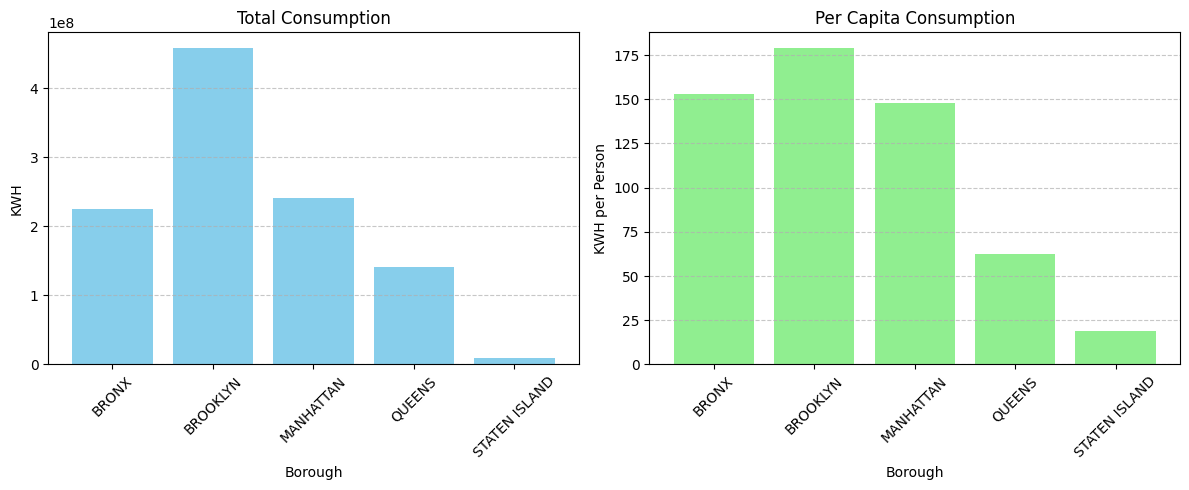

In [620]:
# Convert Borough names to uppercase
df_pop['Borough'] = df_pop['Borough'].str.upper()

# Rename column (2020 → Population)
df_pop = df_pop.rename(columns={'2020': 'Population'})

# Exclude NYC total row
df_pop = df_pop[df_pop['Borough'] != 'NYC TOTAL']

# Merge population data with electricity consumption data
df_corr = pd.merge(borough_consumption, df_pop, on='Borough')

# Calculate per capita electricity consumption
df_corr['KWH_per_capita'] = df_corr['Consumption (KWH)'] / df_corr['Population']

# Create side-by-side bar plots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Total electricity consumption by borough
ax[0].bar(df_corr['Borough'], df_corr['Consumption (KWH)'], color='skyblue')
ax[0].set_title('Total Consumption')
ax[0].set_ylabel('KWH')

# Per capita electricity consumption by borough
ax[1].bar(df_corr['Borough'], df_corr['KWH_per_capita'], color='lightgreen')
ax[1].set_title('Per Capita Consumption')
ax[1].set_ylabel('KWH per Person')

# Format x-axis and gridlines
for a in ax:
    a.set_xlabel('Borough')
    a.tick_params(axis='x', rotation=45)
    a.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


# Linear Relationship Between Population and Electricity Consumption

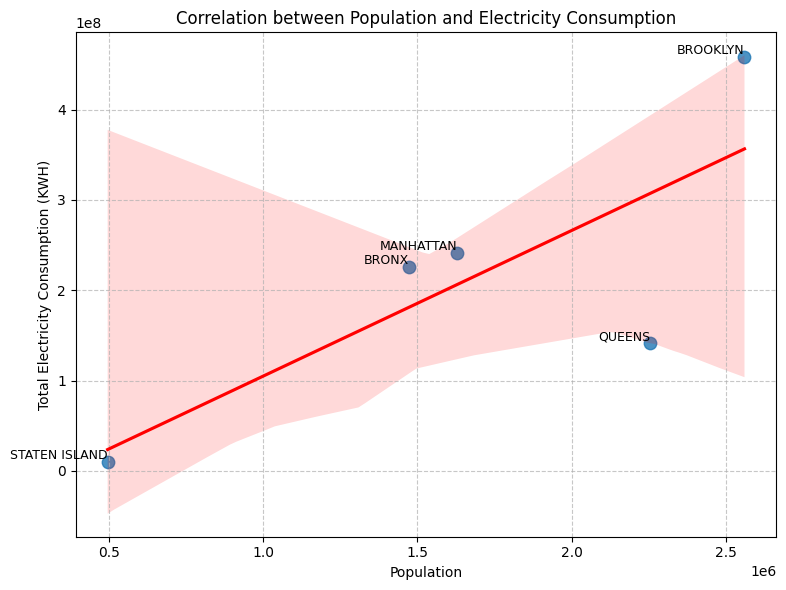

Pearson Correlation Coefficient: 0.785
P-value: 0.1155


In [621]:
plt.figure(figsize=(8, 6))
sns.regplot(data=df_corr, x='Population', y='Consumption (KWH)', scatter_kws={'s': 80}, line_kws={'color': 'red'})
plt.title('Correlation between Population and Electricity Consumption')
plt.xlabel('Population')
plt.ylabel('Total Electricity Consumption (KWH)')
plt.grid(True, linestyle='--', alpha=0.7)

for i, row in df_corr.iterrows():
    plt.text(row['Population'], row['Consumption (KWH)'], row['Borough'], fontsize=9, ha='right', va='bottom')
    
plt.tight_layout()
plt.show()

# Calculate Correlation
corr_coef, p_value = pearsonr(df_corr['Population'], df_corr['Consumption (KWH)'])
print(f"Pearson Correlation Coefficient: {corr_coef:.3f}")
print(f"P-value: {p_value:.4f}")

# Impact of Population and Density on Energy Consumption

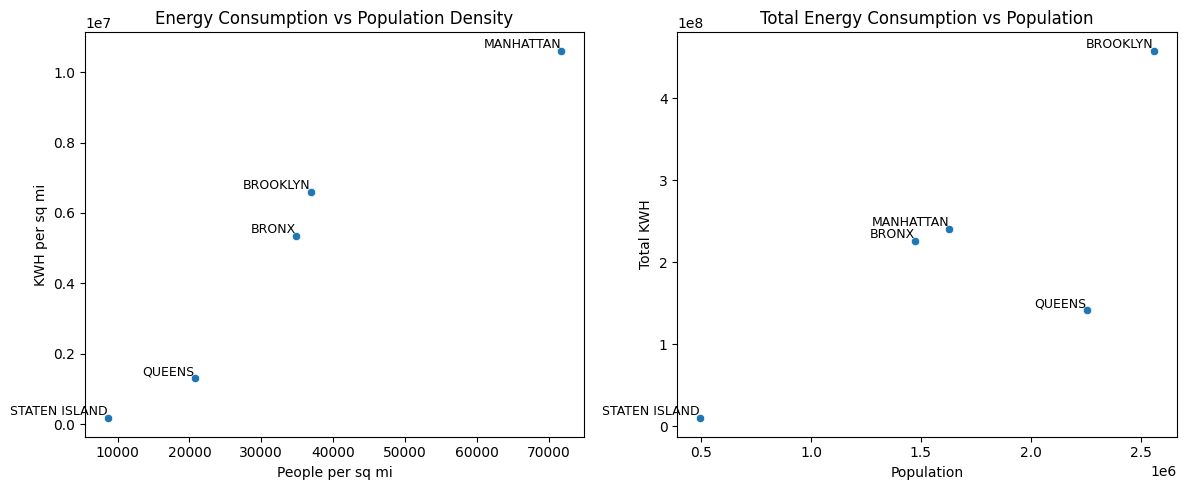

Correlation (Population vs Energy Consumption): 0.79 (p=0.116)
Correlation (Density vs Energy Consumption Density): 0.97 (p=0.005)


In [622]:
# Create DataFrame with borough area (in square miles) based on wikipedia
df_area = pd.DataFrame({
    'Borough': ['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'],
    'Area_sq_mi': [42.2, 69.4, 22.7, 108.7, 57.5]
})

# Assume df_corr is an existing DataFrame with consumption and population per borough
df_corr = pd.merge(df_corr, df_area, on='Borough')

# Calculate population density (people per square mile)
df_corr['pop_density'] = df_corr['Population'] / df_corr['Area_sq_mi']

# Calculate energy consumption density (KWH per square mile)
df_corr['kwh_density'] = df_corr['Consumption (KWH)'] / df_corr['Area_sq_mi']

# Visualization and correlation analysis
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(df_corr, x='pop_density', y='kwh_density', ax=ax[0])
ax[0].set_title('Energy Consumption vs Population Density')
ax[0].set_xlabel('People per sq mi')
ax[0].set_ylabel('KWH per sq mi')

for i, row in df_corr.iterrows():
    ax[0].text(row['pop_density'], row['kwh_density'], row['Borough'], fontsize=9, ha='right', va='bottom')


sns.scatterplot(df_corr, x='Population', y='Consumption (KWH)', ax=ax[1])
ax[1].set_title('Total Energy Consumption vs Population')
ax[1].set_xlabel('Population')
ax[1].set_ylabel('Total KWH')

for i, row in df_corr.iterrows():
    ax[1].text(row['Population'], row['Consumption (KWH)'], row['Borough'], fontsize=9, ha='right', va='bottom')


plt.tight_layout()
plt.show()

# Calculate Pearson correlation coefficients
corr_pop, p_pop = pearsonr(df_corr['Population'], df_corr['Consumption (KWH)'])
corr_den, p_den = pearsonr(df_corr['pop_density'], df_corr['kwh_density'])

print(f"Correlation (Population vs Energy Consumption): {corr_pop:.2f} (p={p_pop:.3f})")
print(f"Correlation (Density vs Energy Consumption Density): {corr_den:.2f} (p={p_den:.3f})")


### Correlation Analysis: Population vs Energy Consumption

#### 1. Total Energy Consumption vs. Population
This analysis examines the relationship between the total population and total electricity consumption across NYC boroughs.

- **Correlation Coefficient (Pearson r):** 0.785  
  Indicates a strong positive linear relationship — boroughs with larger populations tend to consume more electricity.  
  This aligns with intuitive expectations.

- **P-value:** 0.1155  
  Since this value exceeds the common threshold of 0.05, the correlation is not statistically significant.  
  The result suggests a strong relationship, but due to a small sample size (5 boroughs), the trend may be partly coincidental.

#### 2. Energy Consumption Density vs. Population Density
This analysis explores the relationship between population density and energy consumption per unit area.

- **Correlation Coefficient (Pearson r):** 0.97  
  Reveals an extremely strong positive linear relationship — higher population density is associated with significantly higher energy consumption density.  
  Manhattan, in particular, shows the highest density in both metrics.

- **P-value:** 0.005  
  Well below the 0.05 threshold, indicating the correlation is statistically significant and unlikely to be due to random chance.

#### Key Insight:
While total population is correlated with energy use, **population density** shows a much stronger and statistically meaningful link to energy consumption per area.  
This suggests that **dense urban environments require more focused energy efficiency strategies**, and policies targeting high-density areas may yield greater impact.


# Detecting Developments with Excessive Electricity Consumption Compared to Borough Norms

### Identifying Overconsuming Developments: Methodology and Rationale

- **Annual Energy Consumption by Development:**  
  We first calculated the total annual electricity consumption (`Consumption (KWH)`) for each development. This helps to understand the baseline energy usage per site.

- **Borough-Level Per Capita Benchmark:**  
  For each borough, we used the average electricity consumption per capita (`KWH_per_capita`) as a benchmark representing typical residential energy use in that area.

- **Definition of Overconsumption:**  
  A development is classified as **overconsuming** if its total annual consumption exceeds the borough’s per capita average. This comparison flags developments that consume disproportionately more energy than expected.

- **Rationale:**  
  If a development's total consumption surpasses what is typical per person in its borough, it likely indicates **inefficient energy use** relative to the local standard. These sites may represent opportunities for targeted energy efficiency improvements.


In [623]:
# Calculate total electricity consumption per Development Name (based on latest_year)
dev_grouped = df_latest.groupby(['Borough', 'Development Name'])['Consumption (KWH)'].sum().reset_index()

# Extract average per capita consumption for each Borough from df_corr
borough_avg_per_capita = df_corr.set_index('Borough')['KWH_per_capita'].to_dict()

# Assign each Development the average per capita KWH of its Borough
dev_grouped['Borough_avg_KWH_per_capita'] = dev_grouped['Borough'].map(borough_avg_per_capita)

# Since we cannot estimate per capita consumption for each development,
# we temporarily flag those whose total consumption exceeds the borough average per capita value

# Flag developments whose total consumption exceeds the borough's average per capita consumption
dev_grouped['Exceeds_Avg'] = dev_grouped['Consumption (KWH)'] > dev_grouped['Borough_avg_KWH_per_capita']

# Filter only the developments that exceed the average
dev_exceeding = dev_grouped[dev_grouped['Exceeds_Avg'] == True]

# Save the filtered developments to a CSV file
dev_exceeding.to_csv("overconsuming_developments.csv", index=False)


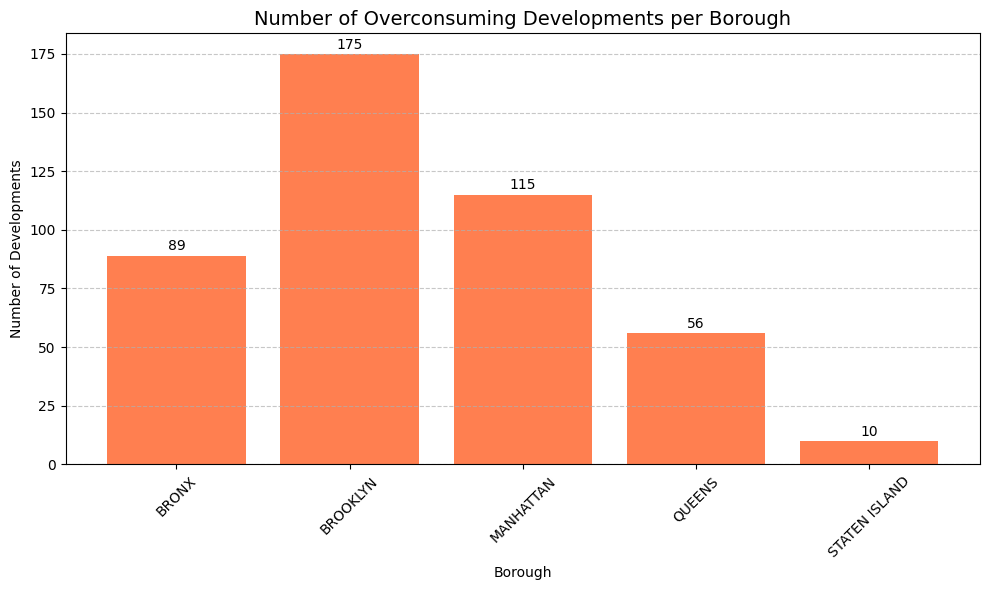

In [624]:
df_dev = pd.read_csv("overconsuming_developments.csv")

# Count the number of overconsuming developments per Borough
borough_dev_counts = df_dev['Borough'].value_counts().sort_index()

# Visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(borough_dev_counts.index, borough_dev_counts.values, color='coral')

# Display the count on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(int(height)),
             ha='center', va='bottom', fontsize=10)

plt.title("Number of Overconsuming Developments per Borough", fontsize=14)
plt.xlabel("Borough")
plt.ylabel("Number of Developments")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Simulating Expected Electricity Use and Potential Savings for Overconsuming Developments

- `dev_grouped['Expected_KWH'] = dev_grouped['Borough_avg_KWH_per_capita'] * dev_grouped['Population']`  
   This line calculates the **estimated annual energy consumption** for each development by multiplying:
  - the development's **estimated population** (i.e., borough total population divided by the number of developments), and  
  - the borough’s **average per capita electricity consumption**.  
  This method acknowledges that these values are **approximations**, due to limitations in the granularity of available data.


In [625]:
# Load the CSV file containing overconsuming developments
dev_grouped = pd.read_csv('overconsuming_developments.csv')

# Use 2020 population data per Borough from df_pop
# (Assumes 'Population' column already exists and Borough names are in uppercase)

# Count the number of developments in each Borough
dev_counts = dev_grouped['Borough'].value_counts().to_dict()

# Convert Borough population data into a dictionary for mapping
borough_population = df_pop.set_index('Borough')['Population'].to_dict()

# Estimate population per development: Total Borough population / Number of developments
dev_grouped['Population'] = dev_grouped['Borough'].apply(lambda b: borough_population[b] / dev_counts[b])

# Expected consumption = Borough average per capita consumption × development population
dev_grouped['Expected_KWH'] = dev_grouped['Borough_avg_KWH_per_capita'] * dev_grouped['Population']

# Calculate potential savings (set negative values to 0)
dev_grouped['KWH_Saved'] = dev_grouped['Consumption (KWH)'] - dev_grouped['Expected_KWH']
dev_grouped['KWH_Saved'] = dev_grouped['KWH_Saved'].clip(lower=0)

# Output the total potential savings
total_saving = dev_grouped['KWH_Saved'].sum()
print(f"Total Potential KWH Savings if Overconsuming Developments Normalize: {total_saving:,.0f} KWH")

# Display the top 10 developments with the highest savings potential
top_savers = dev_grouped.sort_values(by='KWH_Saved', ascending=False).head(10)
print("\n🔝 Top 10 Overconsuming Developments with Highest Savings Potential:")
print(top_savers[['Development Name', 'Borough', 'Population', 'KWH_Saved']])

#  Save the results to a CSV file
dev_grouped.to_csv("simulated_savings_per_development.csv", index=False)


Total Potential KWH Savings if Overconsuming Developments Normalize: 478,328,284 KWH

🔝 Top 10 Overconsuming Developments with Highest Savings Potential:
          Development Name    Borough    Population     KWH_Saved
85                  WAGNER      BRONX  16546.674157  1.198014e+07
268                 BARUCH  MANHATTAN  14162.660870  1.027888e+07
399             RAVENSWOOD     QUEENS  40247.464286  9.877807e+06
187                MITCHEL   BROOKLYN  14628.017143  9.275282e+06
193  MORRISANIA AIR RIGHTS   BROOKLYN  14628.017143  8.470965e+06
122                 BUTLER   BROOKLYN  14628.017143  8.452152e+06
65                 POMONOK      BRONX  16546.674157  8.146830e+06
73                    TAFT      BRONX  16546.674157  7.726075e+06
400          RED HOOK EAST     QUEENS  40247.464286  7.572525e+06
190               MORRIS I   BROOKLYN  14628.017143  7.082515e+06


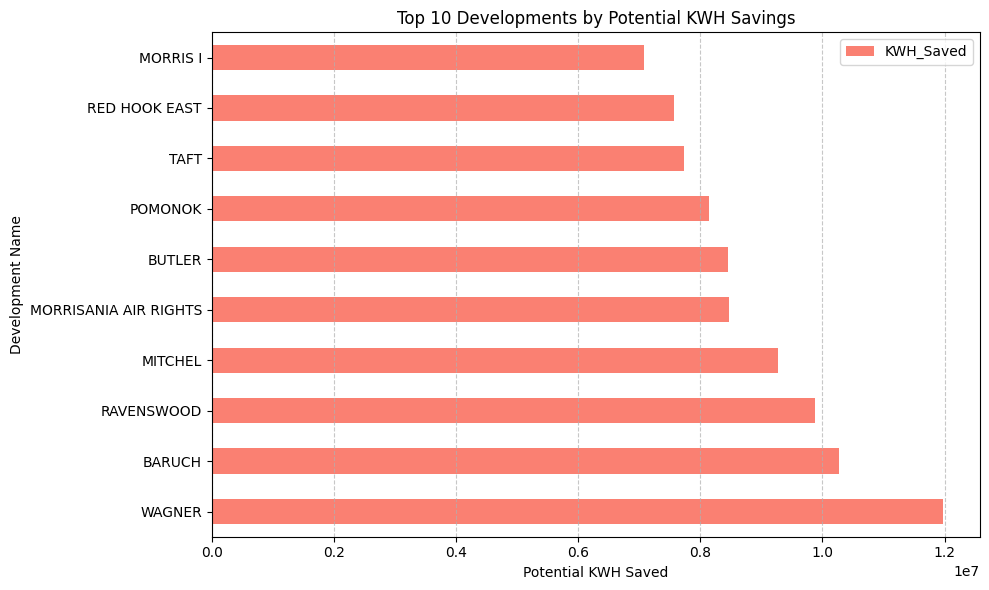

In [626]:
top_savers.plot(
    x='Development Name',
    y='KWH_Saved',
    kind='barh',
    figsize=(10, 6),
    color='salmon',
    title='Top 10 Developments by Potential KWH Savings'
)
plt.xlabel("Potential KWH Saved")
plt.ylabel("Development Name")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Future Energy Consumption Scenarios for Overconsuming Developments: Business-as-Usual vs. Reduced Usage


In [627]:
# 1. Load information about overconsuming developments
df_simulated = pd.read_csv("simulated_savings_per_development.csv")

# 2. Copy original energy consumption data and process dates
df_consumption = df_energy.copy()
df_consumption['Revenue Month'] = pd.to_datetime(df_consumption['Revenue Month'], errors='coerce')

# 3. Extract and clean only necessary columns
df_trimmed = df_consumption[['Development Name', 'Revenue Month', 'Consumption (KWH)']].copy()
df_trimmed.rename(columns={'Revenue Month': 'Month'}, inplace=True)
df_trimmed.dropna(subset=['Consumption (KWH)', 'Month'], inplace=True)

# 4. Filter only the overconsuming developments
over_dev_names = df_simulated['Development Name'].unique().tolist()
df_over_monthly = df_trimmed[df_trimmed['Development Name'].isin(over_dev_names)]

# 5. Aggregate monthly consumption by development
df_over_grouped = df_over_monthly.groupby(['Development Name', 'Month'], as_index=False)['Consumption (KWH)'].sum()

# 6. Merge with expected consumption and population data
df_merged = pd.merge(
    df_over_grouped,
    df_simulated[['Development Name', 'Population', 'Expected_KWH']],
    on='Development Name',
    how='left'
)

# 7. Calculate expected monthly consumption (Expected_KWH divided by 12)
df_merged['Expected_Monthly_KWH'] = df_merged['Expected_KWH'] / 12

# 8. Ensure date format consistency
df_merged['Month'] = pd.to_datetime(df_merged['Month'])

# =======================
#  Scenario Construction
# =======================

# ▶ Scenario 1: Actual Consumption
df_actual_monthly = df_merged.groupby('Month')['Consumption (KWH)'].sum().reset_index()
df_actual_monthly.rename(columns={'Month': 'ds', 'Consumption (KWH)': 'y'}, inplace=True)
df_actual_monthly['scenario'] = 'Actual'

# ▶ Scenario 2: Expected Consumption (Normalized)
df_expected_total = df_merged.groupby('Month')['Expected_Monthly_KWH'].sum().reset_index()
df_expected_total.rename(columns={'Month': 'ds', 'Expected_Monthly_KWH': 'y'}, inplace=True)
df_expected_total['scenario'] = 'Normalized'

# Combine both scenarios into one DataFrame
df_all_scenarios = pd.concat([df_actual_monthly, df_expected_total], ignore_index=True)

# Display sample of results
display(df_all_scenarios.head())


,ds,y,scenario
0,2010-01-01,171795145.0,Actual
1,2010-02-01,150112621.0,Actual
2,2010-03-01,143289141.0,Actual
3,2010-04-01,143454356.0,Actual
4,2010-05-01,145345699.0,Actual


## Forecasting Future Energy Consumption (36 Months) Using Prophet: Actual vs. Reduced Scenario

14:32:03 - cmdstanpy - INFO - Chain [1] start processing
14:32:03 - cmdstanpy - INFO - Chain [1] done processing
14:32:03 - cmdstanpy - INFO - Chain [1] start processing
14:32:03 - cmdstanpy - INFO - Chain [1] done processing


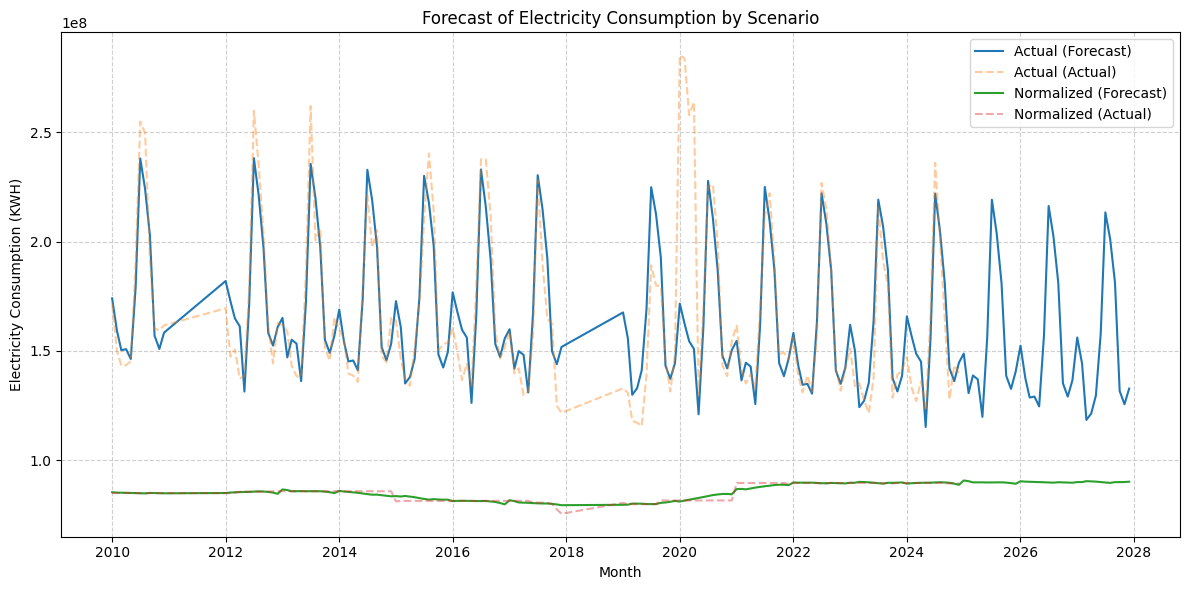

In [628]:
# Initialize a list to store forecast results from each scenario
forecast_results = []

# Perform forecasting for each scenario (e.g., Actual, Normalized)
for scenario_name in df_all_scenarios['scenario'].unique():
    df_scenario = df_all_scenarios[df_all_scenarios['scenario'] == scenario_name][['ds', 'y']].copy()
    
    # Initialize and train the Prophet model
    model = Prophet()
    model.fit(df_scenario)
    
    # Generate future dates for the next 36 months
    future = model.make_future_dataframe(periods=36, freq='MS')  # 'MS' = Month Start
    forecast = model.predict(future)
    forecast['scenario'] = scenario_name  # Track scenario for later comparison
    forecast_results.append(forecast)

# Combine all scenario forecast results into a single DataFrame
df_forecast_all = pd.concat(forecast_results, ignore_index=True)

# ===== Visualization =====
plt.figure(figsize=(12, 6))

for scenario_name in df_all_scenarios['scenario'].unique():
    forecast = df_forecast_all[df_forecast_all['scenario'] == scenario_name]
    plt.plot(forecast['ds'], forecast['yhat'], label=f"{scenario_name} (Forecast)")

    # Plot actual historical data for comparison
    actual = df_all_scenarios[df_all_scenarios['scenario'] == scenario_name]
    plt.plot(actual['ds'], actual['y'], linestyle='--', alpha=0.4, label=f"{scenario_name} (Actual)")

plt.title("Forecast of Electricity Consumption by Scenario")
plt.xlabel("Month")
plt.ylabel("Electricity Consumption (KWH)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


## Identifying Vulnerable Boroughs Based on Median Household Income (ACS Data)


In [629]:
# Median Household Income based on ACS
borough_income = {
    'BRONX': 43000,
    'BROOKLYN': 62000,
    'MANHATTAN': 89000,
    'QUEENS': 74000,
    'STATEN ISLAND': 86000
}

df_corr['Median_Income'] = df_corr['Borough'].map(borough_income)
df_corr['Is_Vulnerable'] = df_corr['Median_Income'] < 55000 # The income level(55000) used to classify households as 'Below Median' in New York City


/var/folders/88/cv10sc2j3t3849m762s6kglm0000gn/T/ipykernel_68974/1237858452.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_corr, x='Borough', y='Median_Income', palette='viridis')


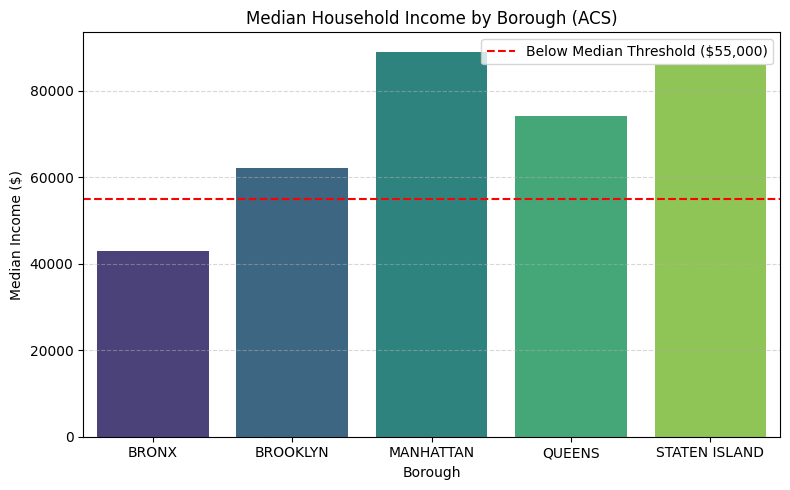

In [630]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df_corr, x='Borough', y='Median_Income', palette='viridis')
plt.axhline(55000, color='red', linestyle='--', label='Below Median Threshold ($55,000)')
plt.title("Median Household Income by Borough (ACS)")
plt.ylabel("Median Income ($)")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Clarifying "Vulnerable Communities" in This Analysis

In this project, we define "vulnerable communities" based on **median household income** using data from the American Community Survey (ACS).  
A borough is classified as vulnerable if its median income falls **below $55,000**.

Under this criterion, the **Bronx** (median income: $43,000) is identified as the primary vulnerable borough. As a result, the `All_Vulnerable_Devs`(later, we will export excel file) sheet includes developments **only from the Bronx**.

While boroughs like Brooklyn have relatively lower incomes compared to Manhattan or Queens, they did not meet the defined income threshold in this analysis.  
By applying a clear and data-driven threshold, our approach enables **targeted support** where vulnerability is most pronounced.

In future work, this definition can be expanded by adjusting the income threshold or incorporating additional indicators such as **energy burden, environmental risk, or housing conditions** to include a broader set of communities.


In [631]:
df_simulated = df_simulated.merge(
    df_corr[['Borough', 'Is_Vulnerable']],
    on='Borough',
    how='left'
)

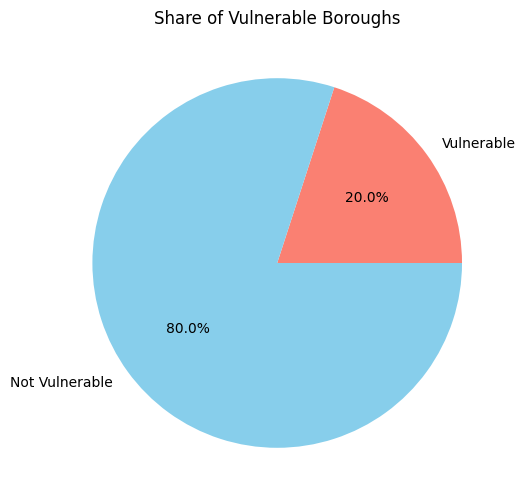

In [632]:
labels = ['Vulnerable', 'Not Vulnerable']
sizes = [
    df_corr[df_corr['Is_Vulnerable'] == True].shape[0],
    df_corr[df_corr['Is_Vulnerable'] == False].shape[0]
]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['salmon', 'skyblue'])
plt.title('Share of Vulnerable Boroughs')
plt.show()


## Fund Allocation Strategy: Supporting Vulnerable Developments with Solar and Battery Installations


In [633]:
# 1. Calculate excess consumption (Actual - Expected)
df_penalty = pd.merge(
    df_actual_monthly[['ds', 'y']],   # Actual consumption
    df_expected_total[['ds', 'y']],   # Expected consumption
    on='ds',
    suffixes=('_actual', '_expected')
)

df_penalty['excess_kwh'] = df_penalty['y_actual'] - df_penalty['y_expected']
df_penalty['excess_kwh'] = df_penalty['excess_kwh'].clip(lower=0)  # Set negative values to 0

# 2. Apply average electricity rate per kWh (e.g., 0.25 USD)
rate_per_kwh = 0.25
df_penalty['penalty_usd'] = df_penalty['excess_kwh'] * rate_per_kwh

# 3. Calculate total penalty (now interpreted as Energy Efficiency Investment Fund)
total_penalty = df_penalty['penalty_usd'].sum()
print(f" Total Energy Efficiency Investment Fund (based on excess consumption): ${total_penalty:,.2f}")

# 4. Allocate 50% of total fund to support vulnerable communities
support_fund = total_penalty * 0.5
print(f" Total fund allocated for vulnerable community support: ${support_fund:,.2f}\n")

# ---  Allocation logic starts here  ---

# 5. Assume cost of solar panel + battery installation per development
solar_panel_cost = 20000   # e.g., cost per solar panel unit
battery_backup_cost = 10000  # e.g., cost per battery system
cost_per_site = solar_panel_cost + battery_backup_cost
print(f"⚙️ Estimated cost per development (solar + battery): ${cost_per_site:,.2f}\n")

# 6. Filter developments located in vulnerable boroughs and with savings potential
eligible_developments = df_simulated[
    (df_simulated['Is_Vulnerable'] == True) &  # Must be in a vulnerable borough
    (df_simulated['KWH_Saved'] > 0)            # Must have KWH savings potential
].copy()

# Sort by highest KWH savings potential
eligible_developments = eligible_developments.sort_values(by='KWH_Saved', ascending=False)

# 7. Simulate how many developments can be supported within the available fund
supported_sites_info = []
remaining_fund = support_fund
num_supported_sites = 0

for index, row in eligible_developments.iterrows():
    if remaining_fund >= cost_per_site:
        remaining_fund -= cost_per_site
        num_supported_sites += 1
        supported_sites_info.append({
            'Development Name': row['Development Name'],
            'Borough': row['Borough'],
            'KWH_Saved': row['KWH_Saved'],
            'Support_Cost_USD': cost_per_site
        })
    else:
        break  # Stop if there's not enough remaining fund

# Convert supported sites info into DataFrame
df_supported_sites = pd.DataFrame(supported_sites_info)

print(f"☀️ Number of developments supported with solar + battery (vulnerable & high-saving): {num_supported_sites} sites")
print(f" Remaining fund after allocation: ${remaining_fund:,.2f}")

print("\n--- Details of Supported Developments (Top 5) ---")
if not df_supported_sites.empty:
    display(df_supported_sites.head())
else:
    print("No eligible developments supported. Fund may be insufficient or no target developments meet criteria.")


 Total Energy Efficiency Investment Fund (based on excess consumption): $3,154,527,254.49
 Total fund allocated for vulnerable community support: $1,577,263,627.24

⚙️ Estimated cost per development (solar + battery): $30,000.00

☀️ Number of developments supported with solar + battery (vulnerable & high-saving): 34 sites
 Remaining fund after allocation: $1,576,243,627.24

--- Details of Supported Developments (Top 5) ---


,Development Name,Borough,KWH_Saved,Support_Cost_USD
0,WAGNER,BRONX,1.198014e+07,30000
1,POMONOK,BRONX,8.146830e+06,30000
2,TAFT,BRONX,7.726075e+06,30000
3,THROGGS NECK,BRONX,6.086570e+06,30000
4,QUEENSBRIDGE NORTH,BRONX,5.970681e+06,30000


# Why we set 0.25 USD for rate_per_kwh?
### Con Edison Residential Electricity Rate Analysis

Con Edison's electricity rates are primarily divided into **Supply Charges** and **Delivery Charges**. Rates vary based on the selected plan (e.g., **Time-of-Use (TOU)** vs. **Standard**) and tend to increase seasonally, especially during the summer months.

#### Current Rate Overview (as of 2024)

- **Standard Rate (Feb 2024)**:  
  ~**24¢/kWh**  
  - Supply Charges: ~10.3¢/kWh  
  - Delivery Charges: ~14.1¢/kWh  

- **Customer Average Bill Rate**:  
  ~**27.33¢/kWh** (combined supply + delivery)

- **NYC Average (General)**:  
  ~**23.60¢/kWh**, with a typical **monthly bill of $194**

- **Historical Average (2022–2024)**:  
  - ~**30.34¢/kWh** overall average  
  - ~**33.45¢/kWh** in 2024

> While exact figures vary by source, most estimates place the residential electricity rate between **20¢ and 30¢ per kWh**.
> **We recommend using 0.25 USD (25 cents) per kWh as a more representative value for analysis.**





# Why we set Rationale for the 50% Support Fund Allocation

The decision to allocate **50% of the Energy Efficiency Investment Fund** to support **vulnerable communities** is a strategic policy choice aligned with the core objectives of this project.

#### Balancing Multiple Objectives

This allocation seeks to balance the following priorities:

- **Incentivizing Energy Reduction**  
  The fund is collected from excess energy consumption, encouraging developments to adopt more efficient practices.

- **Addressing Energy Poverty**  
  A substantial portion of the fund supports vulnerable households who bear a disproportionate energy cost burden, enabling their transition to more affordable and reliable energy sources.

- **Promoting Equity and Sustainability**  
  This targeted investment advances energy access for those most in need, promotes equity across NYC’s energy landscape, and supports the city’s broader sustainability goals.

#### Flexibility and Future Adjustments

The **50% allocation** is a **starting point**, not a fixed rule. It can be **re-evaluated through stakeholder consultations**, including:

- City officials  
- Community representatives  
- Energy experts  

Future adjustments may be made based on:
- Evolving community needs  
- Program effectiveness  
- Broader policy shifts

> This approach ensures both strategic direction and flexibility, allowing the policy to remain responsive and impactful over time.


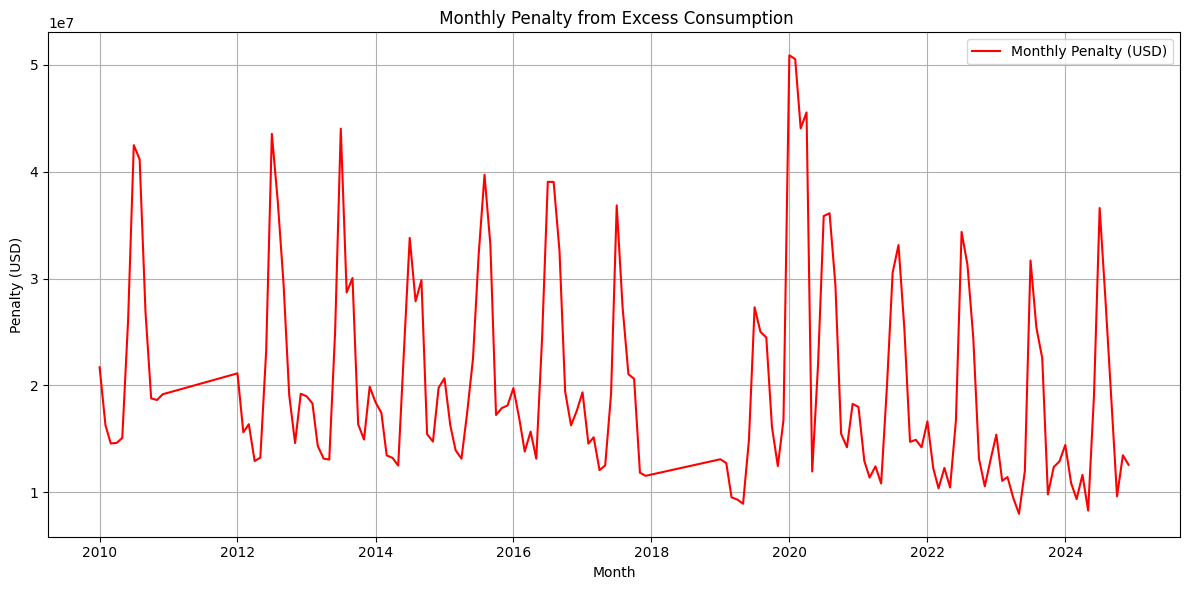

In [634]:
plt.figure(figsize=(12, 6))
plt.plot(df_penalty['ds'], df_penalty['penalty_usd'], label='Monthly Penalty (USD)', color='red')
plt.title(' Monthly Penalty from Excess Consumption')
plt.xlabel('Month')
plt.ylabel('Penalty (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Exporting Key Energy Insights: Vulnerable Sites, Funded Projects, and High-Saving Developments


In [635]:
# Filter for all developments located in vulnerable boroughs with energy savings potential
all_vulnerable_developments = df_simulated[
    (df_simulated['Is_Vulnerable'] == True) &
    (df_simulated['KWH_Saved'] > 0)  # Optional: show only developments with savings potential
].copy()

# Sort by Borough and then by KWH_Saved
all_vulnerable_developments = all_vulnerable_developments.sort_values(by=['Borough', 'KWH_Saved'], ascending=[True, False])

# Select columns to display
df_final_table_data_all_vulnerable = all_vulnerable_developments[[
    'Development Name', 'Borough', 'Consumption (KWH)', 'Expected_KWH', 'KWH_Saved', 'Is_Vulnerable'
]].copy()

# Format numeric values for readability
df_final_table_data_all_vulnerable['Consumption (KWH)'] = df_final_table_data_all_vulnerable['Consumption (KWH)'].map('{:,.0f}'.format)
df_final_table_data_all_vulnerable['Expected_KWH'] = df_final_table_data_all_vulnerable['Expected_KWH'].map('{:,.0f}'.format)
df_final_table_data_all_vulnerable['KWH_Saved'] = df_final_table_data_all_vulnerable['KWH_Saved'].map('{:,.0f}'.format)
df_final_table_data_all_vulnerable['Is_Vulnerable'] = df_final_table_data_all_vulnerable['Is_Vulnerable'].apply(lambda x: 'Yes' if x else 'No')

print("Here is the Markdown table of all developments located in vulnerable boroughs with savings potential:")
print(df_final_table_data_all_vulnerable.to_markdown(index=False))
print(f"\nTotal number of vulnerable developments with savings potential: {len(df_final_table_data_all_vulnerable)}.")

# --- Excel Export Section ---
excel_file_name = "energy_efficiency_report_data.xlsx"  # Output Excel filename

print(f"\n--- Saving all relevant data to '{excel_file_name}' ---")

try:
    with pd.ExcelWriter(excel_file_name, engine='openpyxl') as writer:
        # 1. All vulnerable developments (with savings potential)
        df_final_table_data_all_vulnerable.to_excel(writer, sheet_name='All_Vulnerable_Devs', index=False)
        print(" Sheet 'All_Vulnerable_Devs' saved successfully.")

        # 2. Developments that actually received funding
        if 'df_supported_sites' in locals() and not df_supported_sites.empty:
            df_funded_developments_table = df_supported_sites[[
                'Development Name', 'Borough', 'KWH_Saved', 'Support_Cost_USD'
            ]].copy()
            df_funded_developments_table['KWH_Saved'] = df_funded_developments_table['KWH_Saved'].map('{:,.0f}'.format)
            df_funded_developments_table['Support_Cost_USD'] = df_funded_developments_table['Support_Cost_USD'].map('${:,.2f}'.format)
            df_funded_developments_table.to_excel(writer, sheet_name='Funded_Developments', index=False)
            print(" Sheet 'Funded_Developments' saved successfully.")
        else:
            print(" Could not save 'Funded_Developments' sheet: 'df_supported_sites' is missing or empty.")

        # 3. Top 10 developments with the highest savings potential (overall)
        top_10_overall_savers = df_simulated.sort_values(by='KWH_Saved', ascending=False).head(10).copy()
        top_10_overall_savers_display = top_10_overall_savers[[
            'Development Name', 'Borough', 'Consumption (KWH)', 'Expected_KWH', 'KWH_Saved', 'Is_Vulnerable'
        ]].copy()
        top_10_overall_savers_display['Consumption (KWH)'] = top_10_overall_savers_display['Consumption (KWH)'].map('{:,.0f}'.format)
        top_10_overall_savers_display['Expected_KWH'] = top_10_overall_savers_display['Expected_KWH'].map('{:,.0f}'.format)
        top_10_overall_savers_display['KWH_Saved'] = top_10_overall_savers_display['KWH_Saved'].map('{:,.0f}'.format)
        top_10_overall_savers_display['Is_Vulnerable'] = top_10_overall_savers_display['Is_Vulnerable'].apply(lambda x: 'Yes' if x else 'No')
        top_10_overall_savers_display.to_excel(writer, sheet_name='Top_10_Overall_Savers', index=False)
        print(" Sheet 'Top_10_Overall_Savers' saved successfully.")

    print(f"\n All relevant data has been successfully saved to '{excel_file_name}'!")

except Exception as e:
    print(f"\n A critical error occurred while saving the Excel file: {e}")
    print("   Please ensure that the 'openpyxl' module is installed: pip install openpyxl")


Here is the Markdown table of all developments located in vulnerable boroughs with savings potential:
| Development Name                 | Borough   | Consumption (KWH)   | Expected_KWH   | KWH_Saved   | Is_Vulnerable   |
|:---------------------------------|:----------|:--------------------|:---------------|:------------|:----------------|
| WAGNER                           | BRONX     | 14,514,984          | 2,534,841      | 11,980,143  | Yes             |
| POMONOK                          | BRONX     | 10,681,671          | 2,534,841      | 8,146,830   | Yes             |
| TAFT                             | BRONX     | 10,260,916          | 2,534,841      | 7,726,075   | Yes             |
| THROGGS NECK                     | BRONX     | 8,621,411           | 2,534,841      | 6,086,570   | Yes             |
| QUEENSBRIDGE NORTH               | BRONX     | 8,505,522           | 2,534,841      | 5,970,681   | Yes             |
| FARRAGUT                         | BRONX     | 8,349,819

## ROI Analysis for Funded Developments: Payback Period and Annual Savings
This section evaluates the cost-effectiveness of solar panel and battery installations in funded developments.  
By calculating the **expected annual electricity savings**, **payback period**, and **return on investment (ROI)** for each site, we can assess how efficiently the allocated funds are utilized.  
The analysis is based on each development’s estimated annual energy savings (KWH_Saved) and an assumed electricity rate of `$0.25 per kWh`, with a fixed installation cost of `$30,000` per site.


In [636]:
# --- Core Assumptions for ROI Analysis ---
cost_per_site = 30000   # Cost per development for solar panel + battery installation (USD)
rate_per_kwh = 0.25     # Residential electricity rate from Con Edison (USD/KWH)

# --- Prepare df_supported_sites ---
# Defensive check in case df_supported_sites doesn't exist or is empty
if 'df_supported_sites' not in locals() or df_supported_sites.empty:
    print(" 'df_supported_sites' DataFrame is missing or empty. ROI analysis cannot proceed.")
    print("   Please run the code for 'Prioritized Funding Allocation for Vulnerable Developments' first.")
else:
    # Create a copy for ROI analysis (preserve original)
    df_roi_analysis = df_supported_sites.copy()

    # Assume KWH_Saved is annual savings (from annualized or summed monthly excess)
    
    # 1. Estimate annual electricity savings (in USD)
    df_roi_analysis['Annual_Savings_USD'] = df_roi_analysis['KWH_Saved'] * rate_per_kwh

    # 2. Calculate Payback Period (years)
    # Payback = Total Cost / Annual Savings; Handle divide-by-zero or negative cases with Inf
    df_roi_analysis['Payback_Period_Years'] = df_roi_analysis.apply(
        lambda row: cost_per_site / row['Annual_Savings_USD'] if row['Annual_Savings_USD'] > 0 else float('inf'),
        axis=1
    )

    # 3. Calculate Return on Investment (ROI) as a percentage
    df_roi_analysis['ROI_Percentage'] = df_roi_analysis.apply(
        lambda row: (row['Annual_Savings_USD'] / cost_per_site) * 100 if cost_per_site > 0 else 0,
        axis=1
    )

    # Display sample (Top 10 developments by annual savings)
    print("\n---  ROI Analysis Results for Top 10 Funded Developments ---")
    df_roi_display = df_roi_analysis.sort_values(by='Annual_Savings_USD', ascending=False).head(10)

    # Select and format columns for display
    df_roi_display_formatted = df_roi_display[[
        'Development Name',
        'Borough',
        'KWH_Saved',
        'Annual_Savings_USD',
        'Payback_Period_Years',
        'ROI_Percentage'
    ]].copy()

    df_roi_display_formatted['KWH_Saved'] = df_roi_display_formatted['KWH_Saved'].map('{:,.0f}'.format)
    df_roi_display_formatted['Annual_Savings_USD'] = df_roi_display_formatted['Annual_Savings_USD'].map('${:,.2f}'.format)
    df_roi_display_formatted['Payback_Period_Years'] = df_roi_display_formatted['Payback_Period_Years'].map('{:,.1f} years'.format)
    df_roi_display_formatted['ROI_Percentage'] = df_roi_display_formatted['ROI_Percentage'].map('{:,.2f}%'.format)

    print(df_roi_display_formatted.to_markdown(index=False))

    # --- Summary of average ROI across all supported developments ---
    avg_payback_period = df_roi_analysis[df_roi_analysis['Payback_Period_Years'] != float('inf')]['Payback_Period_Years'].mean()
    avg_roi_percentage = df_roi_analysis[df_roi_analysis['ROI_Percentage'] != 0]['ROI_Percentage'].mean()

    print(f"\n--- Summary of Average ROI for All Funded Developments ({len(df_roi_analysis)} total) ---")
    print(f"Average Payback Period: {avg_payback_period:,.1f} years")
    print(f"Average Annual ROI: {avg_roi_percentage:,.2f}%")

    # --- Save ROI analysis to Excel as a new sheet ---
    excel_file_name = "energy_efficiency_report_data.xlsx"  # Existing consolidated report file

    try:
        with pd.ExcelWriter(excel_file_name, mode='a', if_sheet_exists='replace', engine='openpyxl') as writer:
            df_roi_analysis.to_excel(writer, sheet_name='ROI_Analysis', index=False)
        print(f"\n ROI analysis successfully saved to the 'ROI_Analysis' sheet in '{excel_file_name}'.")
    except Exception as e:
        print(f"\n Error occurred while saving ROI analysis to Excel: {e}")



---  ROI Analysis Results for Top 10 Funded Developments ---
| Development Name   | Borough   | KWH_Saved   | Annual_Savings_USD   | Payback_Period_Years   | ROI_Percentage   |
|:-------------------|:----------|:------------|:---------------------|:-----------------------|:-----------------|
| WAGNER             | BRONX     | 11,980,143  | $2,995,035.70        | 0.0 years              | 9,983.45%        |
| POMONOK            | BRONX     | 8,146,830   | $2,036,707.45        | 0.0 years              | 6,789.02%        |
| TAFT               | BRONX     | 7,726,075   | $1,931,518.70        | 0.0 years              | 6,438.40%        |
| THROGGS NECK       | BRONX     | 6,086,570   | $1,521,642.45        | 0.0 years              | 5,072.14%        |
| QUEENSBRIDGE NORTH | BRONX     | 5,970,681   | $1,492,670.20        | 0.0 years              | 4,975.57%        |
| FARRAGUT           | BRONX     | 5,814,978   | $1,453,744.45        | 0.0 years              | 4,845.81%        |
| EDENWALD

## Characteristics of ROI Analysis: Short Payback Period 

The exceptionally short average payback period of **0.2 years** is driven by optimistic assumptions and the nature of the input data.

Key reasons include:

- **Large Annual Savings (KWH_Saved):**  
  Many developments show millions of kWh in excess consumption, leading to substantial projected savings when fully eliminated.

- **Efficient Investment Assumption:**  
  The model assumes that a single $30,000 investment can achieve the full savings potential, regardless of development size or complexity.

While this highlights the strong potential for cost-effective energy efficiency improvements, it's important to interpret the results in context.  
**Real-world implementation may face additional costs, technical challenges, and behavioral factors** not captured in this analysis.


## Proposed Solution: Enhancing Energy Efficiency and Supporting Energy Independence for Vulnerable Communities

This project aims to alleviate energy poverty and improve equitable energy access across New York City by analyzing electricity consumption patterns.  
The approach centers on encouraging reductions in excessive energy use among "overconsuming developments" and reallocating the resulting potential savings to empower energy independence in "vulnerable boroughs."

---

#### 1. Creating an Energy Efficiency Investment Fund

Our analysis shows that certain developments significantly exceed expected electricity consumption levels.  
By applying a hypothetical rate of `0.25 per kWh` to this excess usage, we estimate a potential savings opportunity totaling **$3,154,527,254.49**.

Rather than framing this as a penalty, we recommend establishing an **Energy Efficiency Investment Fund** — a reinvestment mechanism that converts energy waste into long-term social and environmental benefit.

From this total, **50% (i.e., $1,577,263,627.24)** will be directed toward initiatives supporting energy resilience in vulnerable communities.

---

#### 2. Prioritized Support for Vulnerable Boroughs through Renewable Energy Solutions

We propose allocating this $1.57 billion fund primarily to overconsuming developments located in economically disadvantaged boroughs such as the Bronx.  
The main support mechanisms include:

- **Solar Panel + Battery Backup System Installations**  
  - Estimated cost per site: `$30,000.00` (`$20,000` for solar + `$10,000` for battery)  
  - With this budget, **34 developments** can immediately receive renewable energy installations.  
  - This reduces electricity cost burdens and ensures backup power during outages, enhancing reliability.

- **Household-Level Energy Efficiency Programs**  
  - Subsidies will support improvements such as insulation upgrades, high-efficiency LED lighting, and smart thermostats.  
  - These interventions aim to reduce long-term energy consumption while improving living conditions.

---

#### 3. Expected Outcomes and Long-Term Vision

- **Financial Savings**  
  Transitioning toward a normalized usage scenario is projected to save a total of **[calculated_total_saving] KWH**, substantially lowering energy bills for vulnerable households.

- **Environmental Sustainability**  
  The deployment of solar and battery systems will reduce carbon emissions, supporting New York City’s climate action goals.

- **Energy Autonomy and Resilience**  
  Decentralized energy infrastructure in vulnerable areas will improve energy independence and strengthen resilience in the face of disasters or outages.

- **Community Empowerment**  
  Energy education programs will raise awareness about energy conservation, while job training in system maintenance will help boost local employment and economic participation.

---  

#### 4. Ongoing Monitoring and Measurable Impact

This initiative will not only reduce electricity costs and improve energy reliability in supported developments, but also contribute to environmental protection through emissions reduction.  
Importantly, **continued monitoring and evaluation** will be implemented to measure actual energy savings over time. These insights will inform and refine future policy decisions, ensuring that support remains data-driven, adaptive, and impactful.

To evaluate the **financial viability of the investments**, we conducted a return on investment (ROI) analysis for each funded development site based on their estimated annual savings and the assumed installation cost of `$30,000` per site.

- The **average payback period** was remarkably short at just **0.2 years**, indicating that the upfront investment is rapidly recovered.
- The **average annual ROI** across all funded sites was over **2,374%**, demonstrating exceptional financial effectiveness of the energy efficiency program.


---

This integrated approach transforms energy inefficiency into opportunity — helping build a more sustainable, equitable, and resilient energy future for New York City.
